In [11]:
from keras.datasets import cifar10
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.optimizers import SGD, Adam, RMSprop

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def load_and_format(in_path):
    out_df = pd.read_json(in_path)
    out_images = out_df.apply(lambda c_row: [np.stack([c_row['band_1'],c_row['band_2']], -1).reshape((75,75,2))],1)
    out_images = np.stack(out_images).squeeze()
    return out_df, out_images


In [3]:
base_path = 'data/iceberg'

In [4]:
train_df, train_images = load_and_format(os.path.join(base_path, 'train.json'))
print('training', train_df.shape, 'loaded', train_images.shape)
test_df, test_images = load_and_format(os.path.join(base_path, 'test.json'))
print('testing', test_df.shape, 'loaded', test_images.shape)
train_df.sample(3)

training (1604, 5) loaded (1604, 75, 75, 2)
testing (8424, 4) loaded (8424, 75, 75, 2)


,band_1,band_2,id,inc_angle,is_iceberg
199,"[-23.31403, -22.291029, -20.707455, -24.229328...","[-28.120672, -27.396479, -28.506874, -30.74640...",bdc40587,40.9817,0
587,"[-26.870293, -28.578964, -25.443308, -27.18637...","[-23.772255, -22.944468, -21.165712, -22.55849...",94e0a5db,35.6314,0
1351,"[-27.849041, -28.235186, -25.83572, -25.83572,...","[-29.978146, -31.561813, -32.80481, -32.80481,...",c2b88693,43.7871,0


In [5]:
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
X_train, X_test, y_train, y_test = train_test_split(train_images,
                                                   to_categorical(train_df['is_iceberg']),
                                                    random_state = 2017,
                                                    test_size = 0.5
                                                   )
print('Train', X_train.shape, y_train.shape)
print('Validation', X_test.shape, y_test.shape)

Train (802, 75, 75, 2) (802, 2)
Validation (802, 75, 75, 2) (802, 2)


In [9]:
# network

IMG_CHANNELS = 2
IMG_ROWS = 75
IMG_COLS = 75

#constant
BATCH_SIZE = 128
NB_EPOCH = 20
NB_CLASSES = 2
VERBOSE = 1
VALIDATION_SPLIT = 0.2
OPTIM = RMSprop()

model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=(IMG_ROWS, IMG_COLS, IMG_CHANNELS)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
  
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(NB_CLASSES))
model.add(Activation('softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 75, 75, 32)        608       
_________________________________________________________________
activation_4 (Activation)    (None, 75, 75, 32)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 37, 37, 32)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 37, 37, 32)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 43808)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               22430208  
_________________________________________________________________
activation_5 (Activation)    (None, 512)               0         
__________

In [10]:
# train
#optim = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=OPTIM,
	metrics=['accuracy'])
 
history = model.fit(X_train, y_train, batch_size=BATCH_SIZE,
	epochs=NB_EPOCH, validation_split=VALIDATION_SPLIT, 
	verbose=VERBOSE)
 
print('Testing...')
score = model.evaluate(X_test, y_test,
                     batch_size=BATCH_SIZE, verbose=VERBOSE)
print("\nTest score:", score[0])
print('Test accuracy:', score[1])

#server.launch(model)


Train on 641 samples, validate on 161 samples
Epoch 1/20
641/641 [==============================] - 1s - loss: 6.8542 - acc: 0.5413 - val_loss: 7.8088 - val_acc: 0.5155
Epoch 2/20
641/641 [==============================] - 0s - loss: 7.3676 - acc: 0.5429 - val_loss: 7.8088 - val_acc: 0.5155
Epoch 3/20
641/641 [==============================] - 0s - loss: 7.3173 - acc: 0.5460 - val_loss: 7.8088 - val_acc: 0.5155
Epoch 4/20
641/641 [==============================] - 0s - loss: 7.9428 - acc: 0.5055 - val_loss: 8.3093 - val_acc: 0.4845
Epoch 5/20
641/641 [==============================] - 0s - loss: 8.7757 - acc: 0.4555 - val_loss: 8.3093 - val_acc: 0.4845
Epoch 6/20
641/641 [==============================] - 0s - loss: 8.7757 - acc: 0.4555 - val_loss: 8.3093 - val_acc: 0.4845
Epoch 7/20
641/641 [==============================] - 0s - loss: 8.8008 - acc: 0.4540 - val_loss: 8.3093 - val_acc: 0.4845
Epoch 8/20
641/641 [==============================] - 0s - loss: 8.8008 - acc: 0.4540 - val_l

In [12]:
#save model
model_json = model.to_json()
open('iceberg_architecture.json', 'w').write(model_json)
model.save_weights('iceberg_weights.h5', overwrite=True)

dict_keys(['val_acc', 'loss', 'acc', 'val_loss'])


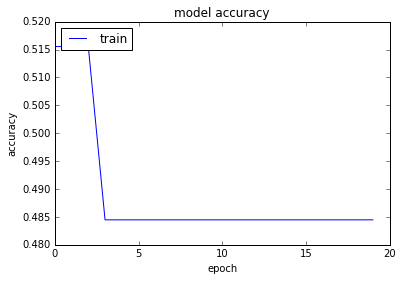

In [13]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
#plt.plot(mo)
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


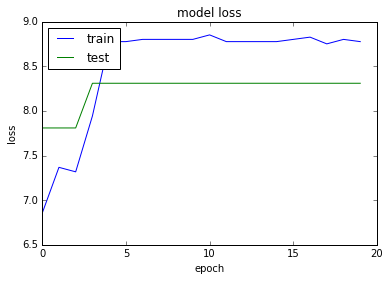

In [14]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()